'99%'

Manuell
Manuell
Manuell
Automat
Manuell
Mer än 50 000 mil
Automat
Manuell
Automat


In [1]:
import datetime

class Car:
    def __init__(self, url):
        self.url = url
        uClient = uReq(self.url)
        page_html = uClient.read()
        uClient.close()
        page_soup = soup(page_html, "html.parser")
        
        price_str = page_soup.find("div", {"class":"TextHeadline1__TextHeadline1Wrapper-sc-18mtyla-0 jwGyyY Price__StyledPrice-crp2x0-0 EkzGO"}).text
        self.price = int(''.join(c for c in price_str.split("(")[0] if c.isdigit()))
        
        date_str = page_soup.find("span", {"class":"TextCallout2__TextCallout2Wrapper-sc-19qvftl-0 gxfHlJ PublishedTime__StyledTime-pjprkp-1 ZAknf"}).text
        self.date = self.get_date(date_str)
        
        self.basic_info = {}
        info_cont = page_soup.find("div", {"class":"AdParams__ParamsWrapper-sc-1vxw014-2 gWITvi"})
        key_div = info_cont.findAll('div', {'class':'TextCallout2__TextCallout2Wrapper-sc-19qvftl-0 gxfHlJ ParamsWithIcons__StyledLabel-hanfos-2 fSgrOG'})
        info_div = info_cont.findAll('div', {'class':'TextCallout1__TextCallout1Wrapper-qzrnab-0 lkIkoj ParamsWithIcons__StyledParamValue-hanfos-3 eZCCwh'})
        
        for key, info in zip(key_div, info_div):
            self.basic_info.update( {key.text : info.text} )
            
        car_features = page_soup.findAll("li", {"class":"CarFeaturesList__ListItem-sc-1sasr52-3 joupKr"})
        self.equipment = [e.text for e in car_features]
        self.description = page_soup.find("div", {"class":"TextBody__TextBodyWrapper-sc-17pzx5f-0 lbkVoL BodyCard__DescriptionPart-sc-15r463q-2 bYSeDO"}).text
        self.sensor = self.has_sensor(self.equipment, self.description)
        self.prev_price = [self.price]
        self.sold = False
        self.milage = int(self.basic_info["Miltal"].split('-')[-1].replace(' ',''))
        try:
            self.hp = int(''.join(c for c in self.basic_info["Hästkrafter"] if c.isdigit()))
        except KeyError:
            self.hp = None
            print(self.url)
        self.year = int(self.basic_info["Modellår"].replace(' ',''))
        #print('Above car costs:', self.price)
            

    def has_sensor(self, equipment, description):
        keywords = ['parkeringssensor', 
                    'backkamera',
                    'psensor',
                    'p-sensor',
                    'kamera',
                    'back-kamera']
        for k in keywords:
            if k in description.casefold():
                return True
        for k in keywords:
            for e in equipment:
                if k in e.casefold():
                    return True
        return False
        
    def get_date(self, string):
        year = '2020'
        if "idag" in string:
            return datetime.datetime.today().date()
        if "igår" in string:
            return datetime.datetime.today().date() - datetime.timedelta(days = 1)
        if 'måndags' in string:
            offset = (datetime.datetime.today().weekday() - 0)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
        if 'tisdags' in string:
            offset = (datetime.datetime.today().weekday() - 1)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
        if 'onsdags' in string:
            offset = (datetime.datetime.today().weekday() - 2)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
        if 'torsdags' in string:
            offset = (datetime.datetime.today().weekday() - 3)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
        if 'fredags' in string:
            offset = (datetime.datetime.today().weekday() - 4)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
        if 'lördags' in string:
            offset = (datetime.datetime.today().weekday() - 5)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
        if 'söndags' in string:
            offset = (datetime.datetime.today().weekday() - 6)%7
            return datetime.datetime.today().date() - datetime.timedelta(days = offset)
            
        
        mounth_dict = {
            'jan.' : '01',
            'feb.' : '02',
            'mars' : '03',
            'apr.' : '04',
            'maj' : '05',
            'juni' : '06',
            'juli' : '07',
            'aug.' : '08',
            'sep.' : '09',
            'okt.' : '10',
            'nov.' : '11',
            'dec.' : '12'
        }
        string = string.replace("Inlagd: ",'')[0:-6].split(' ')
        d = string[0]
        m = mounth_dict[string[1]]
        date_str = year + '-' + m + '-' + d
        date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
        if date > datetime.datetime.today().date():
            date = date - datetime.timedelta(days = 365)
        return date
    
    def update_price(self, new_price):
        if not new_price == self.price:
            self.price = new_price
            self.prev_price.append(self.price)
            print("Updated price:", self.prev_price, car.url)
            
        
        

In [2]:
## Add new cars
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
from IPython.display import clear_output, display
print('started')

import math 
import pickle
import time

#file_name = "cars_at_1588405708.pickle"
#pickle_in = open(file_name, 'rb')
#car_array = pickle.load(pickle_in)
#pickle_in.close()
car_array = []

my_url = f'https://www.blocket.se/annonser/hela_sverige/fordon/bilar?cb=41&cbl1=1&cg=1020&fu=2&gb=1&mye=2013&mys=2010&page=1&sort=date'
uClient = uReq(my_url)
page_html = uClient.read()
uClient.close()
page_soup = soup(page_html, "html.parser")
pages_str = page_soup.find("div", {'data-cy':"search-result-count"}).text
pages = math.ceil(int(''.join(c for c in pages_str if c.isdigit()))/40)

all_car_url = [car.url for car in car_array]

cars_len = display(str(len(car_array)),display_id=True)
i = 1
new_cars = True
found_url = []
for i in range(1, pages+1):
    my_url = f'https://www.blocket.se/annonser/hela_sverige/fordon/bilar?cb=41&cbl1=1&cg=1020&fu=2&gb=1&mye=2013&mys=2010&page={i}&sort=date'
    uClient = uReq(my_url)
    page_html = uClient.read()
    uClient.close()

    page_soup = soup(page_html, "html.parser")
    containers = page_soup.findAll("div", {"class":"styled__Wrapper-sc-1kpvi4z-0 itHtzm"})

    for cont in containers:
        url = 'https://www.blocket.se'+cont['to']
        found_url.append(url)
        if not url in all_car_url:
            print("Added new car", url)
            car_array.append(Car(url))
            cars_len.update(str(len(car_array)))
        else:
            price_str = cont.find("div", {"TextSubHeading__TextSubHeadingWrapper-sc-1ilszdp-0 bcaUdR Price__Wrapper-sc-1v2maoc-0 bNwNaE"})
            price = int(''.join(c for c in price_str.text.split("(")[0] if c.isdigit()))
            for car in car_array:
                if car.url == url:
                    car.update_price(price)

for car in car_array:
    if not car.url in found_url and not car.sold:
        print("Sold car", car.price, car.url)
        car.sold = True
            
c_time = int(time.time())
filename = f"c30_at_{c_time}.pickle"
pickle_out = open(filename, "wb")
pickle.dump(car_array, pickle_out)
pickle_out.close()
print(filename)

started


'60'

Added new car https://www.blocket.se/annons/varmland/volvo_c30_d2_momentum_115hk/90040239
Added new car https://www.blocket.se/annons/stockholm/tillfalle_volvo_c30_d2_/90036891
Added new car https://www.blocket.se/annons/sodermanland/volvo_c30_1_6d/90019372
Added new car https://www.blocket.se/annons/alvsborg/volvo_c30_d2/89986626
Added new car https://www.blocket.se/annons/kronoberg/volvo_c30_3dr_d2_114hk_r_design/90009352
Added new car https://www.blocket.se/annons/goteborg/volvo_c30_d2_r_design/89997900
Added new car https://www.blocket.se/annons/skane/volvo_c30_kinetic/89996811
Added new car https://www.blocket.se/annons/halland/c30_d2_momentum/89980329
Added new car https://www.blocket.se/annons/norrbotten/volvo_c30_momentum__r_design/89967745
Added new car https://www.blocket.se/annons/dalarna/volvo_c30_d2_momentum_r_design/89959895
Added new car https://www.blocket.se/annons/stockholm/volvo_c30_kinetic/89941940
Added new car https://www.blocket.se/annons/goteborg/volvo_c30_d4_mo

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

file_name = "cars_at_1589224345.pickle"
pickle_in = open(file_name, 'rb')
cars = pickle.load(pickle_in)
pickle_in.close()

sorted_cars = sorted(cars, key=lambda x: x.year/(x.milage*x.price), reverse=True)
                     
for x in sorted_cars[0:50]:
    print(x.year/(x.milage*x.price), x.price, x.url)


1.3349713948954473e-05 9700 https://www.blocket.se/annons/stockholm/volvo_v50_kinetic/89818050
1.1629491137295824e-05 7500 https://www.blocket.se/annons/vastmanland/volvo_v50_1_8/89561396
9.552835849326159e-06 10000 https://www.blocket.se/annons/jamtland/volvo_v50_1_8/89576954
8.540788969743393e-06 10000 https://www.blocket.se/annons/uppsala/volvo_v50_2_0_d_kinetic_136hk_las_annonstexte/89772835
6.99337249900692e-06 14000 https://www.blocket.se/annons/skane/volvo_v50_2_0_d_sveriges_billigaste/89835685
5.7401640046858485e-06 10000 https://www.blocket.se/annons/gavleborg/volvo_v50_1_6d___taklucka___drag___startar_ej/89694713
5.191912078129589e-06 42999 https://www.blocket.se/annons/orebro/volvo_v50_1_8_flexifuel_kinetic_125hk/88532648
5.117555818604841e-06 16000 https://www.blocket.se/annons/uppsala/volvo_v50_2_4_addition_140_hk/89797369
4.865631477508273e-06 15000 https://www.blocket.se/annons/skane/volvo_v50_2_0_d_kinetic_136hk/84541450
4.296473718408214e-06 54990 https://www.blocket.s

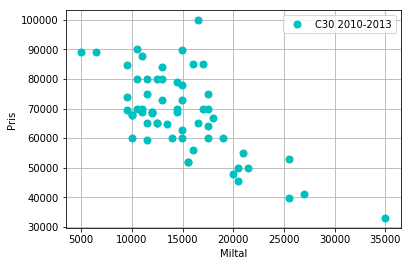

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

file_name = "c30_at_1590177614.pickle"
pickle_in = open(file_name, 'rb')
cars = pickle.load(pickle_in)
pickle_in.close()

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))


'''
milage = [car.milage for car in cars if car.year in [2006, 2007]] 
price = [car.price for car in cars if car.year in [2006, 2007]]
plt.plot(milage,price,'.b', markersize = 20, label = "År: 06-07")

milage = [car.milage for car in cars if car.year in [2009, 2008]] 
price = [car.price for car in cars if car.year in [2009, 2008]]
plt.plot(milage,price,'.g', markersize = 18, label = "År: 08-09")

milage = [car.milage for car in cars if car.year in [2010, 2011]] 
price = [car.price for car in cars if car.year in [2010, 2011]]
plt.plot(milage,price,'.r', markersize = 16, label = "År: 10-11")
         
milage = [car.milage for car in cars if car.year in [2012, 2013]] 
price = [car.price for car in cars if car.year in [2012, 2013]]
plt.plot(milage,price,'.m', markersize = 14, label = "År: 12-13")
         
milage = [car.milage for car in cars if car.year in [2014, 2015, 2016]] 
price = [car.price for car in cars if car.year in [2014, 2015, 2016]]
plt.plot(milage,price,'.c', markersize = 14, label = "År: 14-15-16")  
'''
milage = [car.milage for car in cars] 
price = [car.price for car in cars]
plt.plot(milage,price,'.c', markersize = 14, label = "C30 2010-2013")           
plt.legend()
plt.grid()
#plt.axis([6000,16000, 25000, 55000])
#plt.gcf().autofmt_xdate()
#plt.ylim([60000, 150000])
plt.xlabel('Miltal')
plt.ylabel('Pris')
plt.savefig('v30.png')
plt.show()


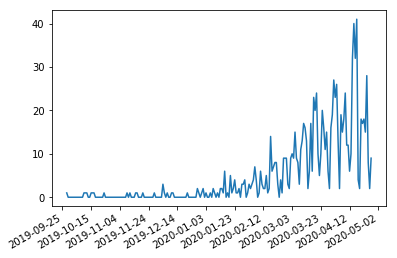

https://www.blocket.se/annons/vasterbotten/volkswagen_golf_1_6_tdi_bluemotion_4motion_11/89599163
https://www.blocket.se/annons/stockholm/volkswagen_golf_1_2_tsi110_p_sensor/89598924
https://www.blocket.se/annons/stockholm/volkswagen_golf_1_4_5_dorrar_tgi_cng_auto_eur/89598132
https://www.blocket.se/annons/stockholm/volkswagen_golf_gti_performance_230hk_b_kamer/89597572
https://www.blocket.se/annons/jonkoping/volkswagen_golf_tsi_125hk_sensorer/89596141
https://www.blocket.se/annons/skane/volkswagen_golf_gt_1_4_tsi__150hk__r_line__hi/89603959
https://www.blocket.se/annons/kronoberg/volkswagen_golf_tsi_110hk_dsg_panorama/89603914
https://www.blocket.se/annons/stockholm/volkswagen_golf_5_dorrar_1_2_tsi_auto_style_e/89603471
https://www.blocket.se/annons/skane/volkswagen_golf_1_2_clbm_81_tsi_m6f/89601473


In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

file_name = "cars_at_1587997969.pickle"
pickle_in = open(file_name, 'rb')
cars = pickle.load(pickle_in)
pickle_in.close()

dates = [car.date for car in cars]
c_date = min(dates)
occurances = []
plot_dates = []
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
while not c_date == tomorrow:
    #print(dates.count(c_date))
    occurances.append(dates.count(c_date))
    plot_dates.append(c_date)
    c_date += datetime.timedelta(days=1)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    
plt.plot(plot_dates,occurances)
        
plt.gcf().autofmt_xdate()
plt.show()

today = datetime.date.today()
yesterday = datetime.date.today() + datetime.timedelta(days=-1)
day_before = datetime.date.today() + datetime.timedelta(days=-2)
todays_cars = [car for car in cars if car.date==today]
yesterday_cars = [car for car in cars if car.date==yesterday]
day_before_cars = [car for car in cars if car.date==day_before]

for car in todays_cars:
    print(car.url)

In [16]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

file_name = "cars_at_1587984227.pickle"
pickle_in = open(file_name, 'rb')
cars = pickle.load(pickle_in)
pickle_in.close()

req = [car for car in cars if car.milage == 5999 and car.year == 2016]

for car in req:
    print(car.price, car.url)
print(len(req))

169000 True False https://www.blocket.se/annons/stockholm/volkswagen_golf_1_4_tsi_dsg_sport__r_line/89431388
129900 True False https://www.blocket.se/annons/halland/volkswagen_golf_1_2_tsi_110/89428275
199900 False True https://www.blocket.se/annons/stockholm/volkswagen_golf_gte_1_4_tsi_dsg_drag/89426844
119900 False True https://www.blocket.se/annons/stockholm/volkswagen_golf_1_2_tsi_110_hk___master/89380208
142500 False False https://www.blocket.se/annons/halland/volkswagen_golf_1_2_tsi_dsg_style_110hk_1_99_/89254571
117000 False False https://www.blocket.se/annons/sodermanland/volkswagen_golf_5_dorrar_tsi_comf_line_blueto/87484907
128500 False False https://www.blocket.se/annons/alvsborg/volkswagen_golf_tsi_110__appconnect_adaptiv_f/89026386
149000 False False https://www.blocket.se/annons/blekinge/volkswagen_golf_sportsvan_1_2_tsi_style_autom/88961968
160000 True False https://www.blocket.se/annons/gavleborg/volkswagen_golf_5_dorrar_1_4_tsi_150_hk_gt_eu/88567959
129900 False False 